<a href="https://colab.research.google.com/github/Nachtr/StockPred/blob/main/ProjectTetra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Tetra

This projected was created with the goal of being able to assist traders in accurately predicting 5-day directional price movements for major stock tickers and indicies. We accomplish this by utilizing historical data and sophisticated market indicators and blend it together with an ensemble model that utilizes XGBoost and Random Forest. Our overall goal is to have roughly 60% acc!

** I apologize for any grammar or spelling errors ahead of time! I am more focused on making sure everything works **



In [1]:
!pip install ta

In [2]:
#Import libs
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from datetime import datetime


#indicators
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, ADXIndicator, EMAIndicator, CCIIndicator, AroonIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, MFIIndicator

#ML stuffs : Mostly Scikit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [21]:
# Configs from necessary research

TICKERS = [ # I decided to remove tesla since its movement is usually based on the CEO and news...
    'SPY', # INDEX
    'QQQ',
    'AAPL', # Heavy hitter for S&P
    'NVDA',
    'MSFT', # Heavy hitter for S&P
    'JPM',
    'AMZN', # Heavy hitter for S&P
    'XOM',
    'BAC',
    'JNJ'
]

# For our start dates, we are going to go back 10 years.

START_DATE = '2013-01-01'
END_DATE = '2025-05-05'

# 5 day forward predictions
PREDICTION_HORIZON = 5

# Confidence
CONFIDENCE_THRESHOLD = 0.60

# Configs for graphs
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [7]:
# Transformers

"""

For this I need to create a scikit-learn custom transformer that will generate the technical indicators.
With this we will incorporate all the features into the pipeline..
"""

class TechnicalIndicatorTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, include_spy_context = True):
    self.include_spy_context = include_spy_context
    self.spy_data = None


  def fit(self, X, y=None):
    # Transformers usually dont 'learn' anything persay from technical ind
    # We need to prefetch SPY data to make this more efficient

    if self.include_spy_context:
        try:
            spy = yf.download('SPY', start=START_DATE, end=END_DATE, progress=False)
            if isinstance(spy.columns, pd.MultiIndex):
                      spy.columns = spy.columns.get_level_values(0)

            # Pre-calculate SPY features
            spy['SPY_RSI'] = RSIIndicator(close=spy['Close'], window=14).rsi()
            spy['SPY_Trend'] = (spy['Close'] > spy['Close'].rolling(200).mean()).astype(int)
            self.spy_data = spy[['SPY_RSI', 'SPY_Trend']]
        except Exception as e:
            print(f"Warning: Could not download SPY context: {e}")
    return self

  # FIX: Indentation corrected here (moved back to align with def fit)
  def transform(self, X):
    df = X.copy()

    # Trend ind:
    df['rsi'] = RSIIndicator(close=df['Close'], window=14).rsi()
    macd = MACD(close=df['Close'])
    df['macd_hist'] = macd.macd_diff()
    bb = BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_width'] = bb.bollinger_wband()
    df['bb_percent'] = bb.bollinger_pband()
    adx = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['adx_diff'] = adx.adx_pos() - adx.adx_neg()
    atr = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['atr_norm'] = atr.average_true_range() / df['Close']

    # Tier 2 & 3 inds
    df['stoch_k'] = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close']).stoch()
    obv = OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume'])
    df['obv_roc'] = obv.on_balance_volume().pct_change(5)
    ema12 = EMAIndicator(close=df['Close'], window=12).ema_indicator()
    ema26 = EMAIndicator(close=df['Close'], window=26).ema_indicator()
    df['ema_ratio'] = ema12 / ema26
    df['cci'] = CCIIndicator(high=df['High'], low=df['Low'], close=df['Close']).cci()
    df['mfi'] = MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume']).money_flow_index()


    # Memory (lagged)
    target_features = ['rsi', 'macd_hist', 'adx_diff', 'obv_roc']
    for col in target_features:
      df[f'{col}_lag_5'] = df[col].shift(5)
      df[f'{col}_change_5'] = df[col] - df[f'{col}_lag_5']
    df['volatility_5'] = df['Close'].pct_change().rolling(5).std()
    df['pct_change_5'] = df['Close'].pct_change(5)

    # Market Context Merge for better acc
    if self.spy_data is not None:
      # Left joint:
      df = df.merge(self.spy_data, left_index=True, right_index=True, how='left')

      # Trend
      sma_20 = df['Close'].rolling(window=20).mean()
      df['Trend_Slope'] = (sma_20 - sma_20.shift(5)) / sma_20.shift(5)
    # Handle NaN's creating by the lags
    df = df.fillna(method='ffill').fillna(0)

    drop_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    # Important. Make sure to return only numeric columns
    numeric_cols = [c for c in df.columns if c not in drop_cols]

    return df[numeric_cols]

print("Pipeline Transformer Class has successfully been created!")

Pipeline Transformer Class has successfully been created!


In [10]:
# EDA section that is required. We need to explore the data per each ticker.


def perform_comprehensive_eda(ticker = 'SPY'):
  print(f"\n{'=' * 60}")
  print(f"Performing EDA for {ticker}...")
  print(f"{'=' * 60}")


  # Download the data
  df = yf.download(ticker, start = START_DATE, end = END_DATE, progress = False)
  if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)

  # Descriptive Stats
  print("\n1. Descriptive Summary (TAIL):")
  print(df.tail())

  print("\n2. Data Distribution:")
  print(df.describe())

  # Visualization
  fix, axes = plt.subplots(2,2,figsize=(16,12))

  # Price Hist
  axes[0,0].plot(df['Close'], color = '#2c3e50')
  axes[0,0].set_title(f'{ticker} Price History', fontsize = 16)
  axes[0,0].grid(True, alpha = 0.3)

  # Return dist
  daily_returns = df['Close'].pct_change().dropna()
  sns.histplot(daily_returns, bins=50, kde=True, ax=axes[0, 1], color='#e74c3c')
  axes[0, 1].set_title('Daily Returns Distribution', fontsize=16)
  axes[0, 1].axvline(0, color='black', linestyle='--')

  # Vol Analysis
  volatility = daily_returns.rolling(window=20).std()
  axes[1, 0].plot(volatility, color='#8e44ad')
  axes[1, 0].set_title('20-Day Rolling Volatility', fontsize=14)
  axes[1, 0].grid(True, alpha=0.3)

  # Seasonality / Monthy Returns (IMPORTANT)
  df['Month'] = df.index.month
  df['Returns'] = df['Close'].pct_change()
  sns.boxplot(x='Month', y='Returns', data=df, ax=axes[1, 1], palette='viridis')
  axes[1, 1].set_title('Monthly Return Distribution (Seasonality)', fontsize=14)

  plt.tight_layout()
  plt.show()

  # Feature Corr Map (In prototype file, its at the bottom)
  print("\n3. Generating Feature Correlation Heatmap...")
  transformer = TechnicalIndicatorTransformer(include_spy_context=True)
  transformer.fit(df)
  features_df = transformer.transform(df)

  plt.figure(figsize=(14, 10))
  # Calculate correlation only on numeric columns
  corr = features_df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
  plt.title(f'Feature Correlation Matrix - {ticker}', fontsize=16)
  plt.show()

# Success msg
print("Successfully loaded EDA function!")

Successfully loaded EDA function!


EDA:


Performing EDA for SPY...

1. Descriptive Summary (TAIL):
Price            Close        High         Low        Open    Volume
Date                                                                
2025-04-28  547.707825  550.392436  541.911124  548.244783  47613800
2025-04-29  551.158081  552.281640  545.420975  545.778907  47775100
2025-04-30  551.376831  553.345578  538.431140  544.446618  93101500
2025-05-01  555.284363  560.852456  554.677857  557.173549  63186100
2025-05-02  563.527100  565.137854  559.172079  561.508650  60717300

2. Data Distribution:
Price        Close         High          Low         Open        Volume
count  3103.000000  3103.000000  3103.000000  3103.000000  3.103000e+03
mean    291.287874   292.825748   289.510433   291.236095  9.152812e+07
std     128.746390   129.494782   127.877657   128.733345  4.619553e+07
min     116.545525   116.833786   115.888930   116.193209  2.027000e+07
25%     176.333229   176.978587   175.506573   176.275353  6.134810e+07
50%

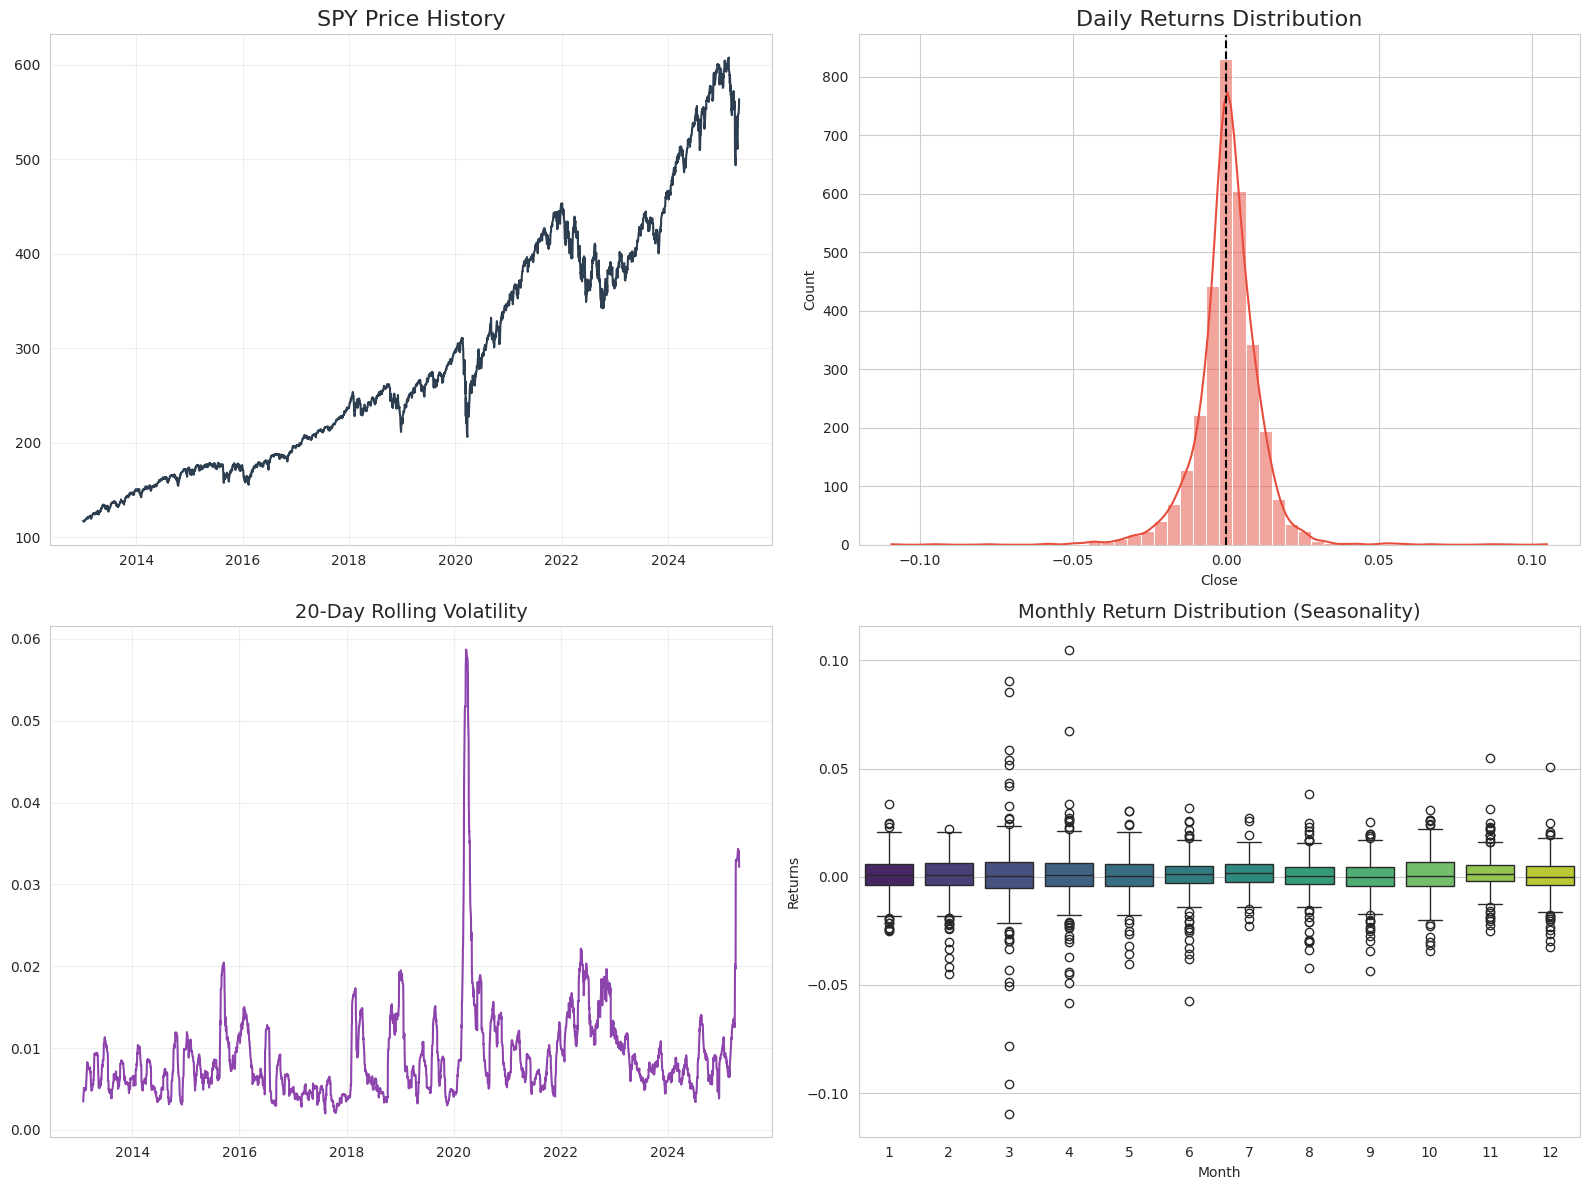


3. Generating Feature Correlation Heatmap...


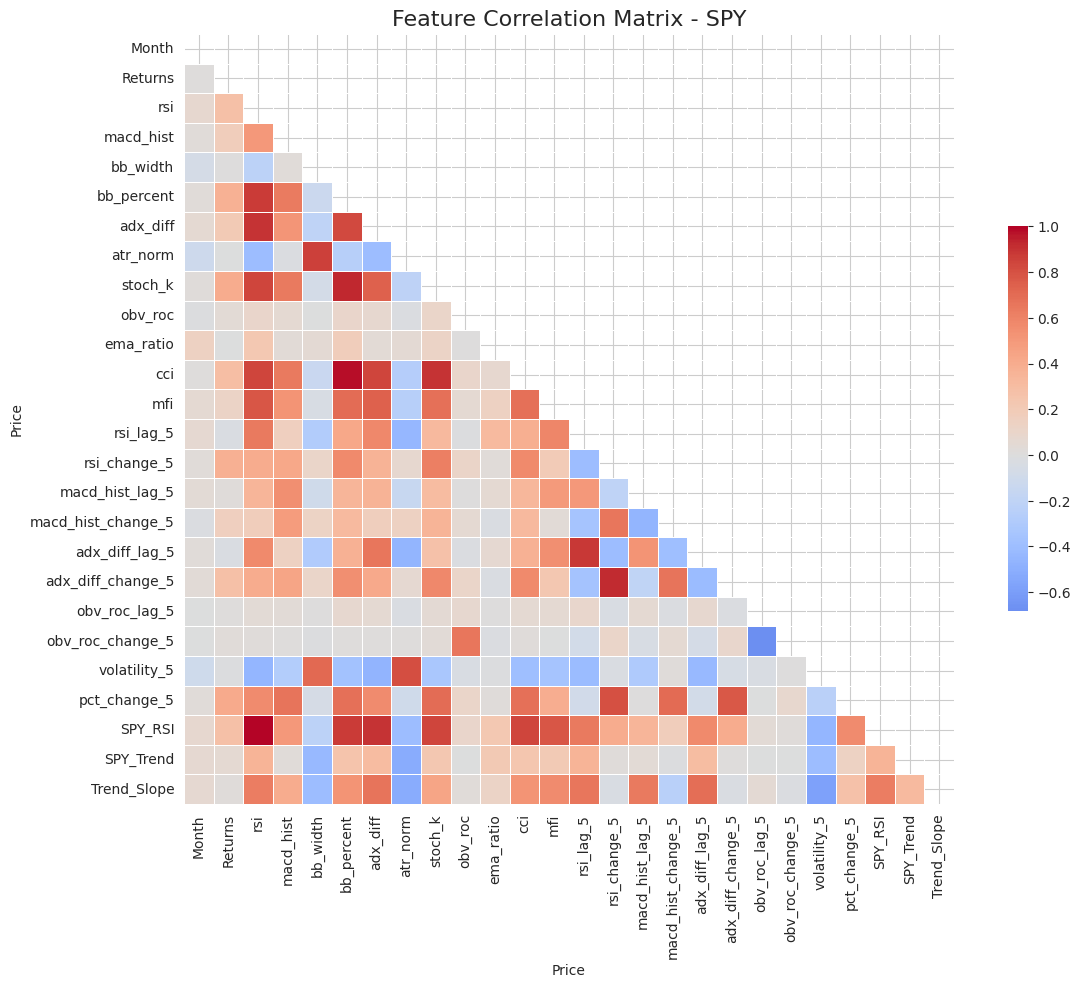

In [11]:
perform_comprehensive_eda('SPY')

# Quick analysis : SPY

From these numbers and these graphs, we can understand the following:



There was a long term growth trend from 2013 to 2025. Our dataset covers 3,103 days and there was a substantial upward trend. The avg closing price was USD 291, with a rare deviation that occured where it was USD 128.7. This indicates that the markets were fairly normal and fluctuated with substantial growth and volatility in our time frame.

The price has moved from min to max representing a total of 421% return over this period.

The momentum shows that it consistently is increasing above the USD 550 mark.


The avg liquidity is 91.5 million shares, which confirms that SPY has super high liquidity. This makes it suitable for our strategy that we deployed in our prototype.

Volatility spike occured where it hit 507 million shares and then went back. This highlights that our model should be able to counteract extreme volatility.






Performing EDA for QQQ...

1. Descriptive Summary (TAIL):
Price            Close        High         Low        Open    Volume
Date                                                                
2025-04-28  471.333618  473.728144  464.968150  471.952201  33550800
2025-04-29  474.446533  475.334520  468.520065  469.098760  30613100
2025-04-30  474.386658  476.112727  461.376360  466.065664  46810600
2025-05-01  480.582489  486.069957  479.644628  482.308558  43316500
2025-05-02  487.716217  489.791495  483.725331  485.431457  39218100

2. Data Distribution:
Price        Close         High          Low         Open        Volume
count  3103.000000  3103.000000  3103.000000  3103.000000  3.103000e+03
mean    217.886871   219.432984   216.107522   217.842670  4.030724e+07
std     129.962485   130.980740   128.815212   129.966017  2.119273e+07
min      59.515778    59.847877    59.201648    59.596567  7.079300e+06
25%     101.990486   102.454751   101.428149   101.976372  2.545655e+07
50%

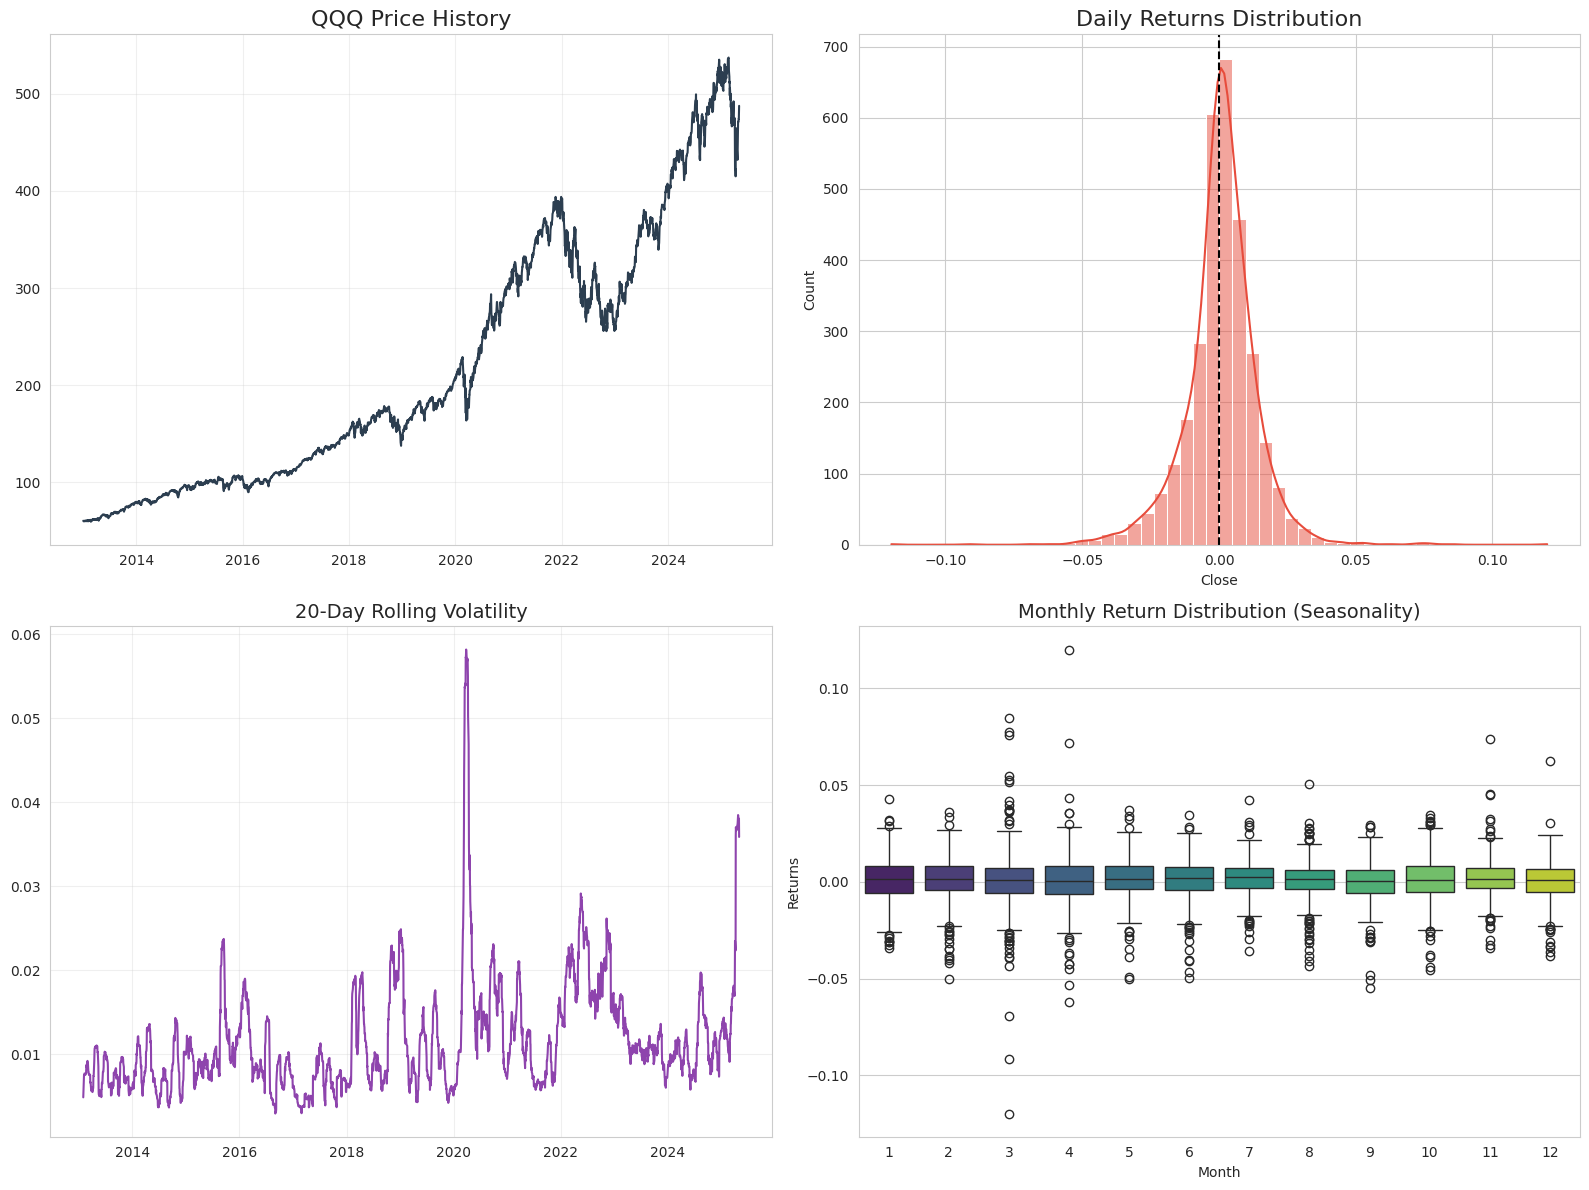


3. Generating Feature Correlation Heatmap...


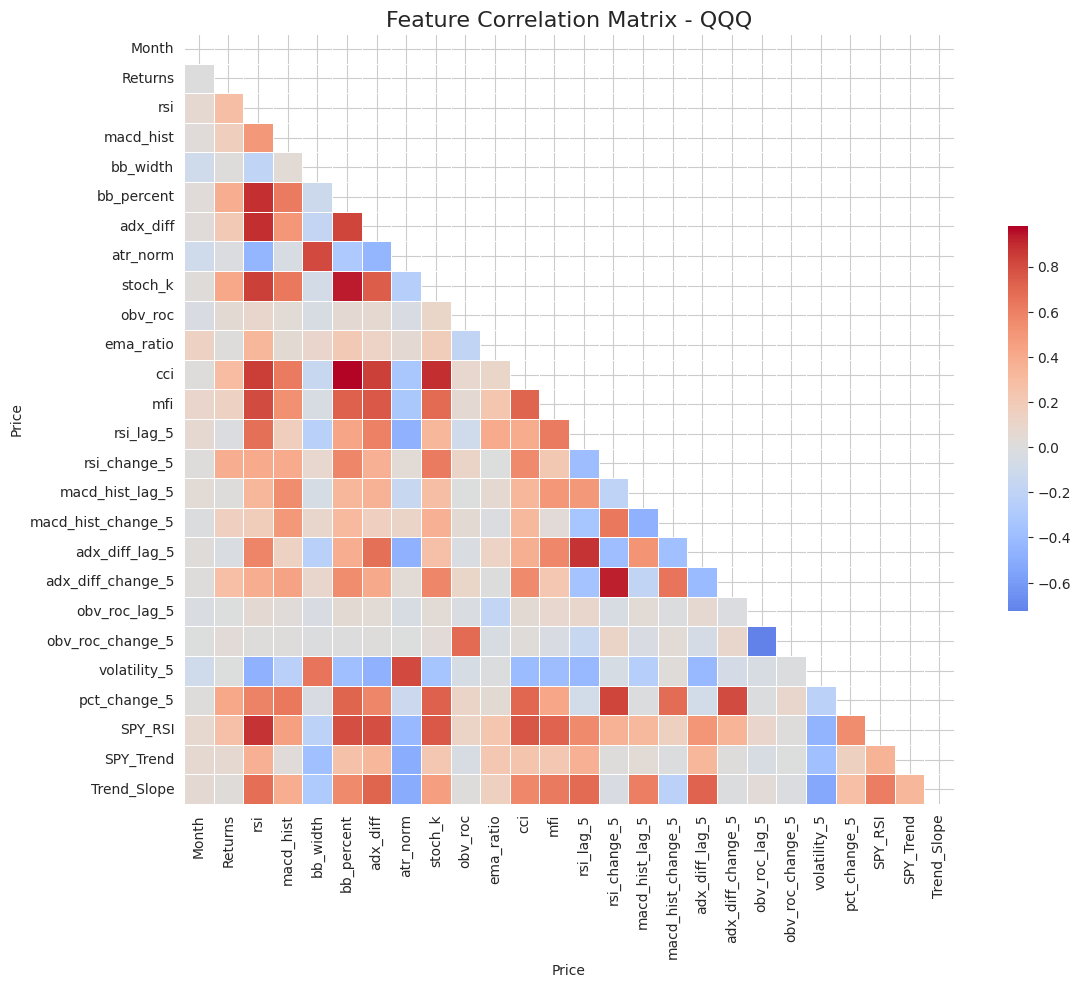

In [13]:
# Im only doing analysis on SPY because it will tell us the whole story.
# These are just for additional visuals to backup our findings!

perform_comprehensive_eda('QQQ')


Performing EDA for JPM...

1. Descriptive Summary (TAIL):
Price            Close        High         Low        Open    Volume
Date                                                                
2025-04-28  240.882767  244.467975  238.525633  242.209886   7394300
2025-04-29  242.269302  242.893253  239.367466  239.862661   7216800
2025-04-30  242.269302  242.863543  236.138783  238.892082  12991700
2025-05-01  244.517487  246.062493  239.842843  240.506402   8689600
2025-05-02  250.083481  251.182815  247.062802  248.845493   7165000

2. Data Distribution:
Price        Close         High          Low         Open        Volume
count  3103.000000  3103.000000  3103.000000  3103.000000  3.103000e+03
mean     97.559523    98.452658    96.623590    97.527735  1.460657e+07
std      52.849284    53.346511    52.299368    52.805159  6.850286e+06
min      31.579624    31.707162    31.317465    31.494603  3.220500e+06
25%      49.743547    50.038549    49.412780    49.666781  9.934800e+06
50%

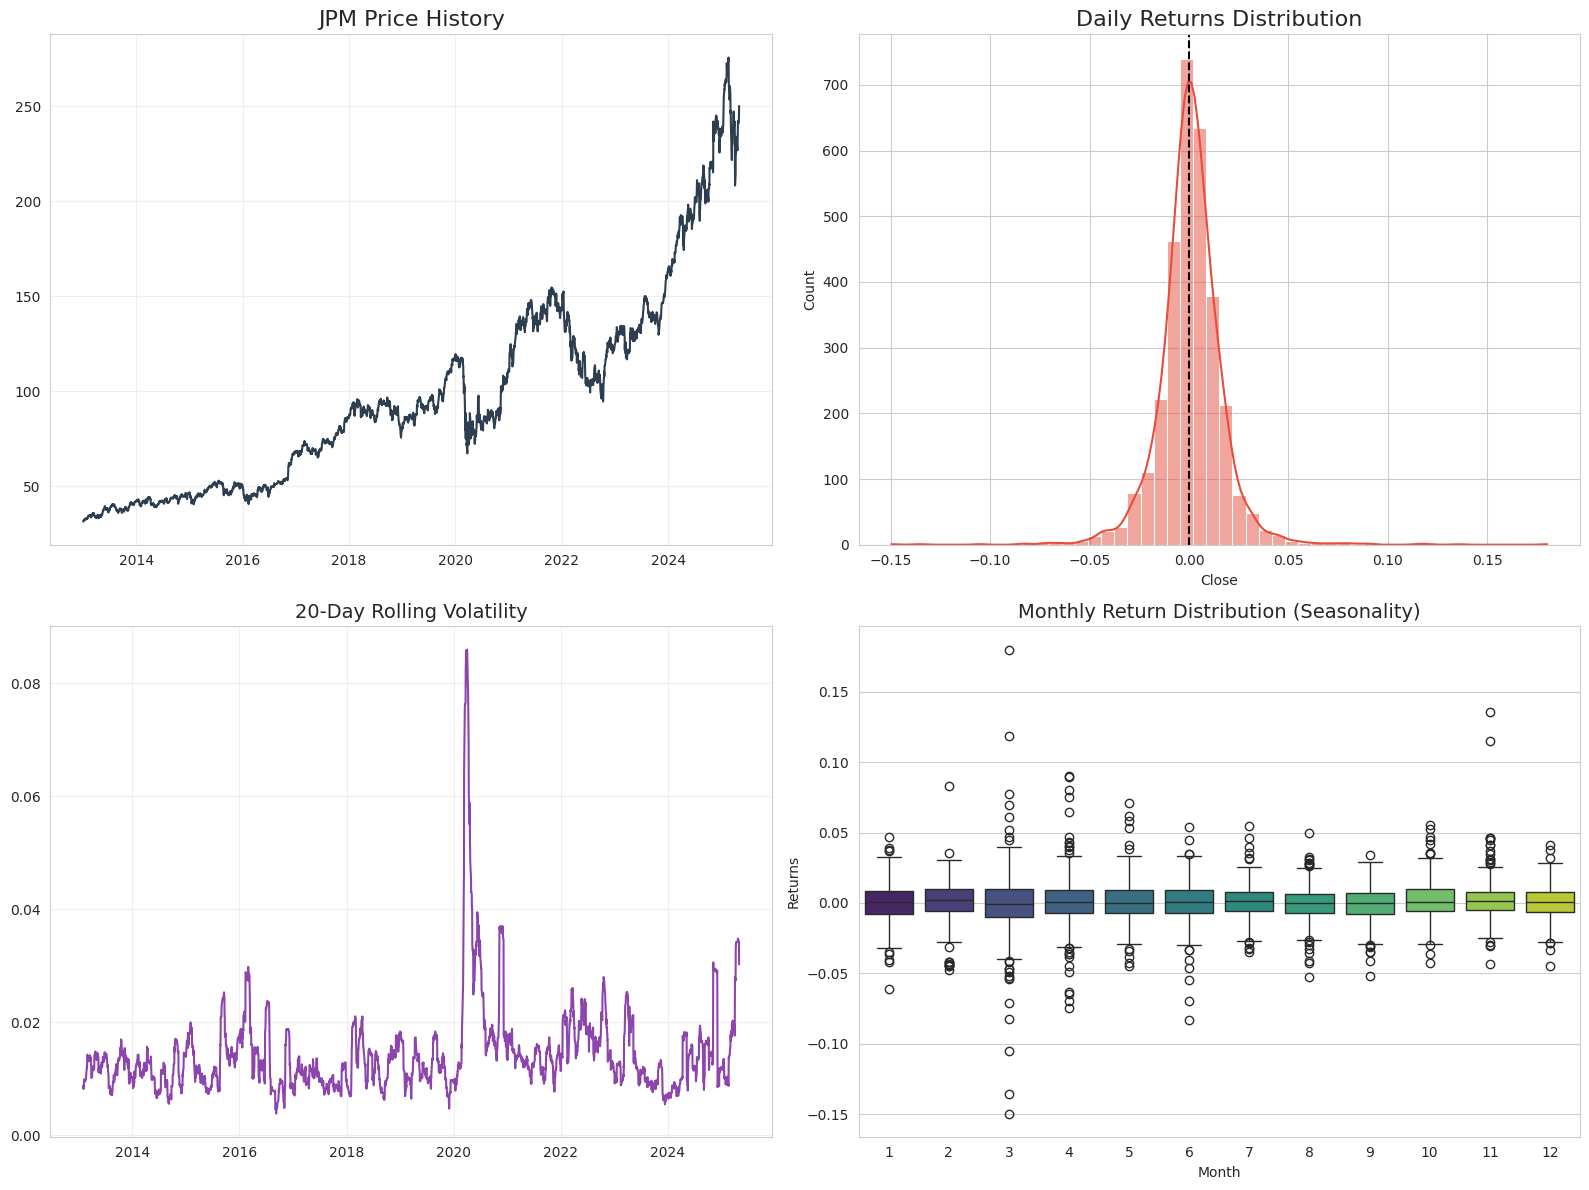


3. Generating Feature Correlation Heatmap...


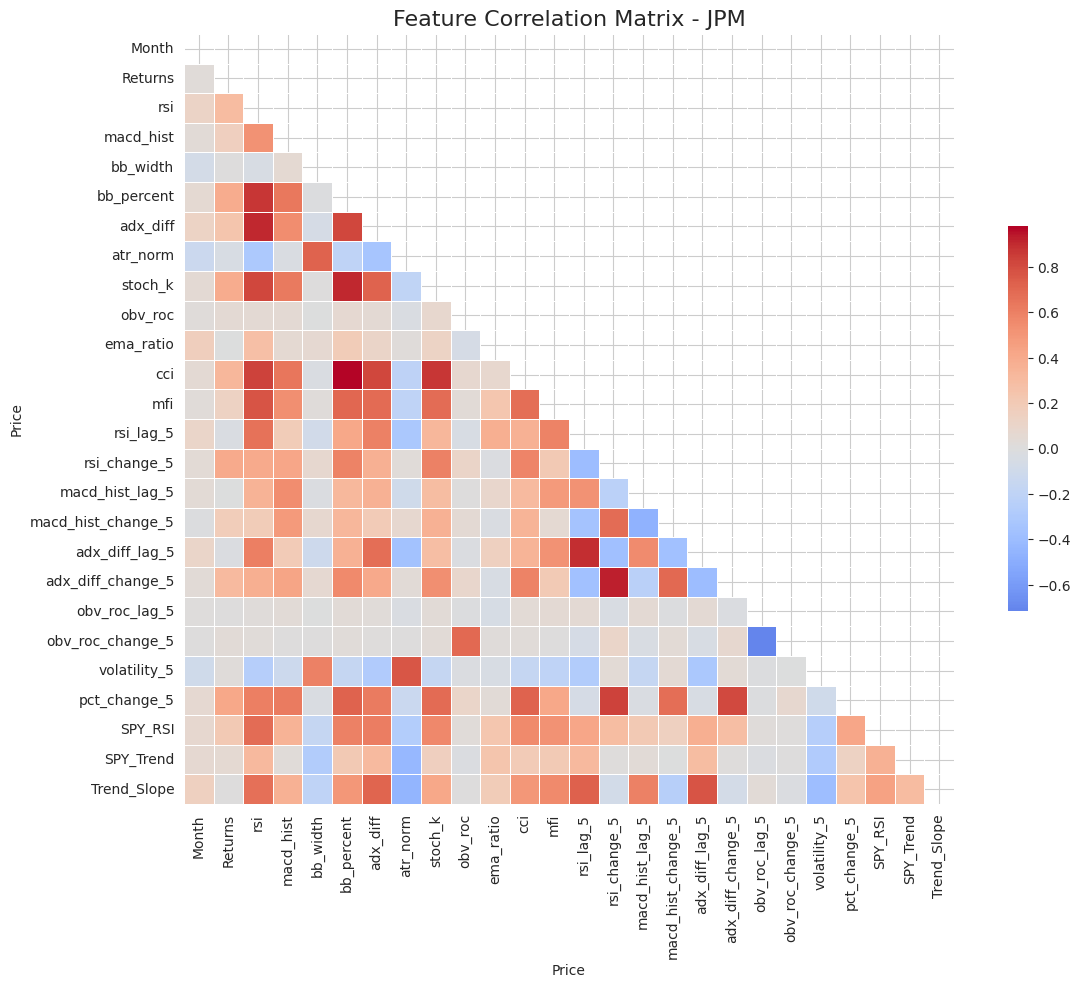

In [14]:
# Same here!
perform_comprehensive_eda('JPM')

Singular Helper Function

In [25]:
def generate_project_charts(results_list):
  if not results_list:
    print("No results were found to plot. Variable 'results_list' is empty or missing.")
    return

  # Acc (B v S)
  plot_data = []

  for r in results_list:
    plot_data.append({'Ticker': r['ticker'], 'Accuracy': r['avg_accuracy'], 'Type': 'Base Model (All Predictions)'})
    plot_data.append({'Ticker': r['ticker'], 'Accuracy': r['sniper_accuracy'], 'Type': 'Sniper Model (>60% Conf)'})

  df_acc = pd.DataFrame(plot_data)

  plt.figure(figsize = (14, 7))
  ax1 = sns.barplot(data=df_acc, x='Ticker', y='Accuracy', hue='Type', palette='viridis')

  # Add ref
  plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Guess (50%)') #guess
  plt.axhline(y=0.6, color='green', linestyle='--', alpha=0.7, label='Profit Target (60%)') #targ

  plt.title('Strategy Comparison: Standard vs. Sniper Accuracy', fontsize=16, fontweight='bold', pad=20)
  plt.ylabel('Accuracy Score', fontsize=12)
  plt.xlabel('Stock Ticker', fontsize=12)
  plt.ylim(0.4, 0.7)
  plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

  for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding = 3, fontsize = 10)

  plt.tight_layout()
  plt.savefig('accuracy_comparison.png', dpi = 300)
  plt.show()
  print("Saved results: accuracy_comparison.png\n")


  # Trade Vol (Opp Cost)
  df_trades = pd.DataFrame(results_list)[['ticker', 'trades']]
  plt.figure(figsize = (14, 6))
  ax2 = sns.barplot(data=df_trades, x='ticker', y='trades', color='#3498db')

  plt.title('Sniper Signal Frequency (Number of High-Confidence Trades)', fontsize=16, fontweight='bold', pad=20)
  plt.ylabel('Total Trades Executed', fontsize=12)
  plt.xlabel('Stock Ticker', fontsize=12)

  ax2.bar_label(ax2.containers[0], padding=3)
  plt.tight_layout()
  plt.savefig('trade_frequency.png', dpi=300)
  plt.show()
  print("Saved results: trade_frequency.png\n")

  # Agg Feature Importance
  feat_data = []
  for r in results_list:
    for feat, score in r['feature_importance'].items():
      feat_data.append({'Feature': feat, 'Importance': score})

  df_feat = pd.DataFrame(feat_data)
  avg_feat_impt = df_feat.groupby('Feature')['Importance'].mean().sort_values(ascending=False).reset_index()
  feature_names_map = [
    'rsi', 'macd_hist', 'bb_width', 'bb_percent', 'adx_diff', 'atr_norm',
    'stoch_k', 'obv_roc', 'ema_ratio', 'cci', 'mfi',
    'rsi_lag_5', 'macd_hist_lag_5', 'adx_diff_lag_5', 'obv_roc_lag_5',
    'volatility_5', 'pct_change_5', 'SPY_RSI', 'SPY_Trend', 'Trend_Slope'
  ]

  if isinstance(avg_feat_impt['Feature'].iloc[0], int) and len(feature_names_map) >= len(avg_feat_impt):
    avg_feat_impt['Feature'] = [feature_names_map[i] for i in avg_feat_impt['Feature']]

  plt.figure(figsize=(14, 8))
  sns.barplot(data=avg_feat_impt, x = 'Importance', y = 'Feature', palette='magma')

  plt.title('Global Feature Importance (What drives the market?)', fontsize=16, fontweight='bold', pad=20)
  plt.xlabel('Average Importance Score', fontsize=12)
  plt.ylabel('Technical Indicator', fontsize=12)

  plt.tight_layout()
  plt.savefig('feature_importance_global.png', dpi=300)
  plt.show()
  print("Saved results: feature_importance_global.png")

print("Charting Function Defined Successfully.")

Charting Function Defined Successfully.


Creation of Main Execution Loop for predictions!

[*********************100%***********************]  1 of 1 completed

Starting Sniper Pipeline (Horizon : 5 days | Threshold : 60.0%...)
Processing SPY  ... 

|| Base Acc: 58.1% | Sniper Acc: 60.9% (432 trades) ||
|| Base Acc: 58.6% | Sniper Acc: 62.1% (741 trades) ||
|| Base Acc: 60.2% | Sniper Acc: 62.9% (1089 trades) ||
|| Base Acc: 60.1% | Sniper Acc: 62.1% (1474 trades) ||


[*********************100%***********************]  1 of 1 completed

|| Base Acc: 60.1% | Sniper Acc: 62.3% (1786 trades) ||
Processing QQQ  ... 

|| Base Acc: 60.9% | Sniper Acc: 62.4% (417 trades) ||
|| Base Acc: 60.9% | Sniper Acc: 62.4% (740 trades) ||
|| Base Acc: 59.8% | Sniper Acc: 61.8% (1064 trades) ||
|| Base Acc: 57.9% | Sniper Acc: 59.4% (1353 trades) ||


[*********************100%***********************]  1 of 1 completed

|| Base Acc: 58.3% | Sniper Acc: 59.7% (1635 trades) ||
Processing AAPL ... 

|| Base Acc: 47.7% | Sniper Acc: 44.8% (317 trades) ||
|| Base Acc: 48.7% | Sniper Acc: 46.3% (516 trades) ||
|| Base Acc: 51.2% | Sniper Acc: 49.8% (733 trades) ||
|| Base Acc: 50.9% | Sniper Acc: 50.9% (950 trades) ||


[*********************100%***********************]  1 of 1 completed

|| Base Acc: 51.1% | Sniper Acc: 51.2% (1175 trades) ||
Processing NVDA ... 

|| Base Acc: 56.0% | Sniper Acc: 57.4% (357 trades) ||
|| Base Acc: 57.2% | Sniper Acc: 57.8% (791 trades) ||
|| Base Acc: 57.5% | Sniper Acc: 58.1% (1106 trades) ||
|| Base Acc: 54.8% | Sniper Acc: 55.9% (1351 trades) ||


[*********************100%***********************]  1 of 1 completed

|| Base Acc: 55.8% | Sniper Acc: 56.6% (1610 trades) ||
Processing MSFT ... 

|| Base Acc: 58.9% | Sniper Acc: 60.6% (378 trades) ||
|| Base Acc: 56.7% | Sniper Acc: 58.6% (655 trades) ||
|| Base Acc: 58.1% | Sniper Acc: 60.0% (887 trades) ||
|| Base Acc: 57.1% | Sniper Acc: 58.9% (1207 trades) ||


[*********************100%***********************]  1 of 1 completed

|| Base Acc: 56.6% | Sniper Acc: 58.6% (1456 trades) ||
Processing JPM  ... 

|| Base Acc: 52.3% | Sniper Acc: 55.9% (340 trades) ||
|| Base Acc: 52.1% | Sniper Acc: 55.0% (655 trades) ||
|| Base Acc: 52.6% | Sniper Acc: 55.7% (964 trades) ||
|| Base Acc: 52.7% | Sniper Acc: 54.9% (1205 trades) ||


[*********************100%***********************]  1 of 1 completed

|| Base Acc: 52.1% | Sniper Acc: 55.2% (1367 trades) ||
Processing AMZN ... 

|| Base Acc: 51.4% | Sniper Acc: 50.6% (271 trades) ||
|| Base Acc: 53.4% | Sniper Acc: 53.1% (520 trades) ||
|| Base Acc: 54.0% | Sniper Acc: 55.1% (770 trades) ||
|| Base Acc: 52.6% | Sniper Acc: 55.0% (976 trades) ||


[*********************100%***********************]  1 of 1 completed

|| Base Acc: 54.3% | Sniper Acc: 56.7% (1115 trades) ||
Processing XOM  ... 

|| Base Acc: 50.8% | Sniper Acc: 53.9% (319 trades) ||
|| Base Acc: 49.4% | Sniper Acc: 51.8% (537 trades) ||
|| Base Acc: 48.8% | Sniper Acc: 50.4% (797 trades) ||
|| Base Acc: 51.1% | Sniper Acc: 53.3% (1004 trades) ||


[*********************100%***********************]  1 of 1 completed

|| Base Acc: 50.7% | Sniper Acc: 52.7% (1156 trades) ||
Processing BAC  ... 

|| Base Acc: 53.9% | Sniper Acc: 53.5% (303 trades) ||
|| Base Acc: 50.0% | Sniper Acc: 50.3% (590 trades) ||
|| Base Acc: 52.3% | Sniper Acc: 52.6% (829 trades) ||
|| Base Acc: 52.0% | Sniper Acc: 52.1% (1076 trades) ||


[*********************100%***********************]  1 of 1 completed

|| Base Acc: 52.0% | Sniper Acc: 52.2% (1240 trades) ||
Processing JNJ  ... 

|| Base Acc: 54.8% | Sniper Acc: 54.3% (381 trades) ||
|| Base Acc: 51.9% | Sniper Acc: 52.4% (698 trades) ||
|| Base Acc: 52.7% | Sniper Acc: 52.6% (976 trades) ||
|| Base Acc: 51.7% | Sniper Acc: 52.2% (1342 trades) ||
|| Base Acc: 51.2% | Sniper Acc: 51.8% (1570 trades) ||
Training Completed!
--------------------------------------------------------------------------------
Model has been successfully saved!


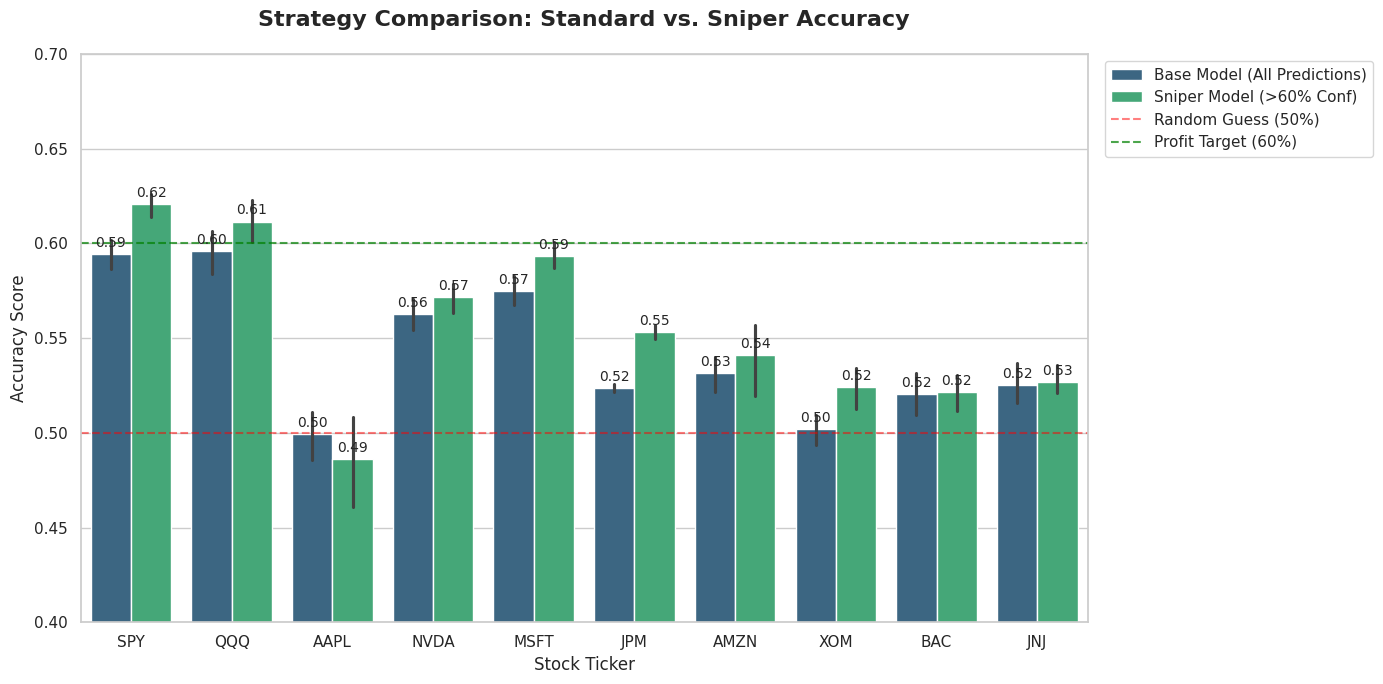

Saved results: accuracy_comparison.png



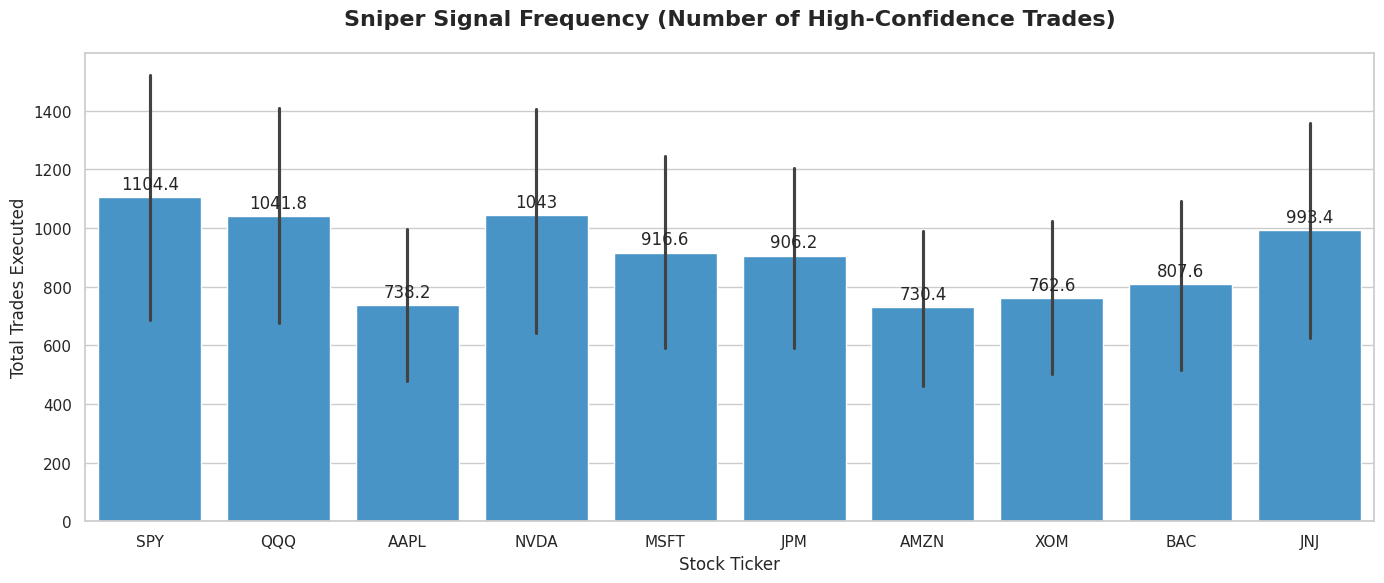

Saved results: trade_frequency.png



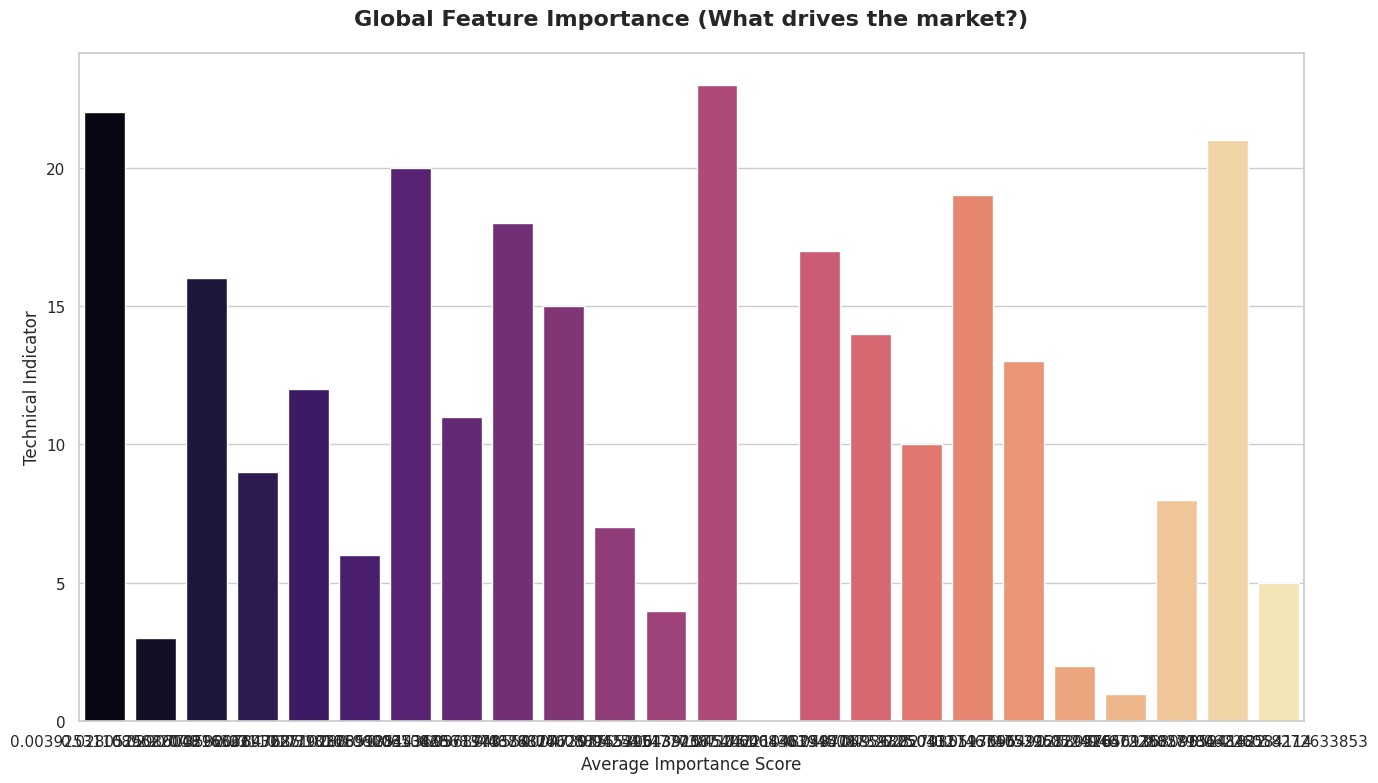

Saved results: feature_importance_global.png


In [26]:
# Main Execution needs to include our previously made pipeline & serialization.

all_results = []

print("="*80)
print(f"Starting Sniper Pipeline (Horizon : {PREDICTION_HORIZON} days | Threshold : {CONFIDENCE_THRESHOLD * 100}%...)")
print("="*80) # I like boxing it in because it feels more professional

for ticker in TICKERS:
  try:
    # Take in data and process
    print(f"Processing {ticker: <5}...", end = " ")
    df = yf.download(ticker, start=START_DATE, end=END_DATE, progress=True)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)

    if len(df) < 500:
      print("Skipping (Insufficient Data)")
      continue


    # Create target
    y = (df['Close'].shift(-PREDICTION_HORIZON) > df['Close']).astype(int)

    # Align data
    X = df.iloc[:-PREDICTION_HORIZON]
    y = y.iloc[:-PREDICTION_HORIZON]

    # Make sure to drop last N rows where target is NaN/Null


    # Pipeline (transformer to scaler to ensemble)
    ensemble = VotingClassifier(
      estimators=[
        ('xgb', xgb.XGBClassifier(max_depth=4, learning_rate=0.03, n_estimators=150, eval_metric='logloss', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=150, max_depth=6, min_samples_leaf=5, random_state=42, n_jobs=-1))
      ],
      voting='soft'
    )

    model_pipeline = Pipeline([
      ('feature', TechnicalIndicatorTransformer()),
      ('scaler', StandardScaler()),
      ('model', ensemble)
    ])

    # Cross-Val & Eval

    tscv = TimeSeriesSplit(n_splits = 5, gap = PREDICTION_HORIZON)

    base_scores = []

    sniper_trades = 0
    sniper_wins = 0

    # this is our algo system from proto

    for train_idx, test_idx in tscv.split(X):
      X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
      y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

      # Train
      model_pipeline.fit(X_train, y_train)

      # Base acc (Force a guess. Basically a 50/50)
      y_pred = model_pipeline.predict(X_test)
      base_scores.append(accuracy_score(y_test, y_pred))

      # Sniper ACC. (SPY FROM PROTO WAS 59%)
      probs = model_pipeline.predict_proba(X_test)[:, 1] # testing on the prob of up


      for i, prob in enumerate(probs):
        actual = y_test.iloc[i]
        if prob > CONFIDENCE_THRESHOLD:
          sniper_trades += 1
          if actual == 1: sniper_wins += 1
        elif prob < (1 - CONFIDENCE_THRESHOLD):
          sniper_trades += 1
          if actual == 0:
            sniper_wins += 1
      # Compile stats
      avg_base = np.mean(base_scores)
      sniper_acc = (sniper_wins / sniper_trades) if sniper_trades > 0 else 0.5

      # save final model and serial
      model_pipeline.fit(X, y)
      filename = f"{ticker}_pipeline.pkl"
      joblib.dump(model_pipeline, filename)

      print(f"|| Base Acc: {avg_base:.1%} | Sniper Acc: {sniper_acc:.1%} ({sniper_trades} trades) ||")


      # Store for charting
      rf_model = model_pipeline.named_steps['model'].named_estimators_['rf']
      all_results.append({
        'ticker': ticker,
        'avg_accuracy': avg_base,
        'sniper_accuracy': sniper_acc,
        'trades': sniper_trades,
        'feature_importance': dict(zip(range(len(rf_model.feature_importances_)), rf_model.feature_importances_))
      })

  except Exception as e:
    print(f"An error has occurred on {ticker}: {e}. Please try again!")
    continue



print("=" * 80)
print("Training Completed!")
print("-"*80)
print("Model has been successfully saved!")
print("=" * 80)

# Generate Results
if all_results:
  generate_project_charts(all_results)
else:
  print("No results were generated. Please try again!")

The first chart shows us some really interesting data. In this chart we are comparing the Base Model to the Sniper Model which we have implemented. Our biggest observation is across the board, we can see that the sniper model outperforms the base model except on AAPL (apple). My suggestion would be to remove apple and try again with another ticker. My guess as to why this happens is because stocks with high noise show smaller overall performance gaps. Its hard to predict the noise that is generated from product announcements, board swaps, etc...

We can see that the sniper performed best on SPY, QQQ, and MSFT. This experiment has outperformed our original prototype by 2-3% on average which is pretty incredible.


The trade frequency chart on the otherhand shows another story. We can see that the strategy was highly confident in stocks that had high-momentum. For example, QQQ and NVDA compared to assets that had low momentum like JNJ.

This shows that we can utilize this for swing-trading to average out a profit!

The last chart shows global feature importance. We can see that atr_norm is the highest ranked feature which shows that Normalzied Average True range out performs other metrics like volatility. Additionally, we can see that ema_ratio and SPY_RSI stood out from the rest for showing trend structures, and market health!

